# Voice Pathology Classification using SVM

This notebook implements a Support Vector Machine (SVM) model for classifying voice recordings as healthy or pathological.

## Import Libraries

In [1]:
import os
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import librosa.display
import IPython.display as ipd
from tqdm import tqdm

## Data Loading and Exploration

In [2]:
# Reading Dataset
df1 = pd.read_excel('Healthy_data.xlsx')
df2 = pd.read_excel('Pathological_data.xlsx')
df = pd.concat([df1, df2], ignore_index=True)
df.head(10)

,Recording Id,Type,Gender,Age,Diagnosis Notes,Pathology,Audio
0,1,n,w,20,Normal,Normal,1-a_n.wav
1,2,n,w,22,Normal,Normal,2-a_n.wav
2,3,n,w,23,Normal,Normal,3-a_n.wav
3,4,n,m,22,Normal,Normal,4-a_n.wav
4,5,n,m,22,Normal,Normal,5-a_n.wav
5,6,n,w,20,Normal,Normal,6-a_n.wav
6,7,n,w,19,Normal,Normal,7-a_n.wav
7,27,n,w,20,Normal,Normal,27-a_n.wav
8,17,n,w,19,Normal,Normal,17-a_n.wav
9,8,n,w,19,Normal,Normal,8-a_n.wav


In [3]:
# Dataset information
print(f"Dataset shape: {df.shape}")
df.info()

Dataset shape: (1490, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Recording Id     1490 non-null   int64 
 1   Type             1490 non-null   object
 2   Gender           1490 non-null   object
 3   Age              1490 non-null   int64 
 4   Diagnosis Notes  1400 non-null   object
 5   Pathology        1490 non-null   object
 6   Audio            1490 non-null   object
dtypes: int64(2), object(5)
memory usage: 81.6+ KB


In [4]:
# Grouping by Type and Gender
type_gender_count = df.groupby(["Type", "Gender"])[['Audio']].count()
type_gender_count

Audio
Type Gender       
n    m         259
     w         428
p    m         302
     w         501

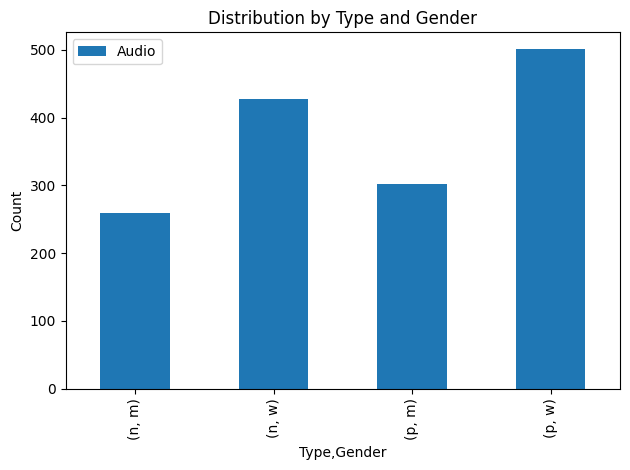

In [5]:
# Visualization
type_gender_count.plot.bar()
plt.title('Distribution by Type and Gender')
plt.ylabel('Count')
plt.tight_layout()

In [6]:
# Get unique values
gender = df.Gender.unique()
pathology = df.Pathology.unique()
print("Gender categories:", gender)
print("Pathology categories:", pathology)

Gender categories: ['w' 'm']
Pathology categories: ['Normal' 'Dysphonia' 'Laryngitis' 'Recurrent palsy']


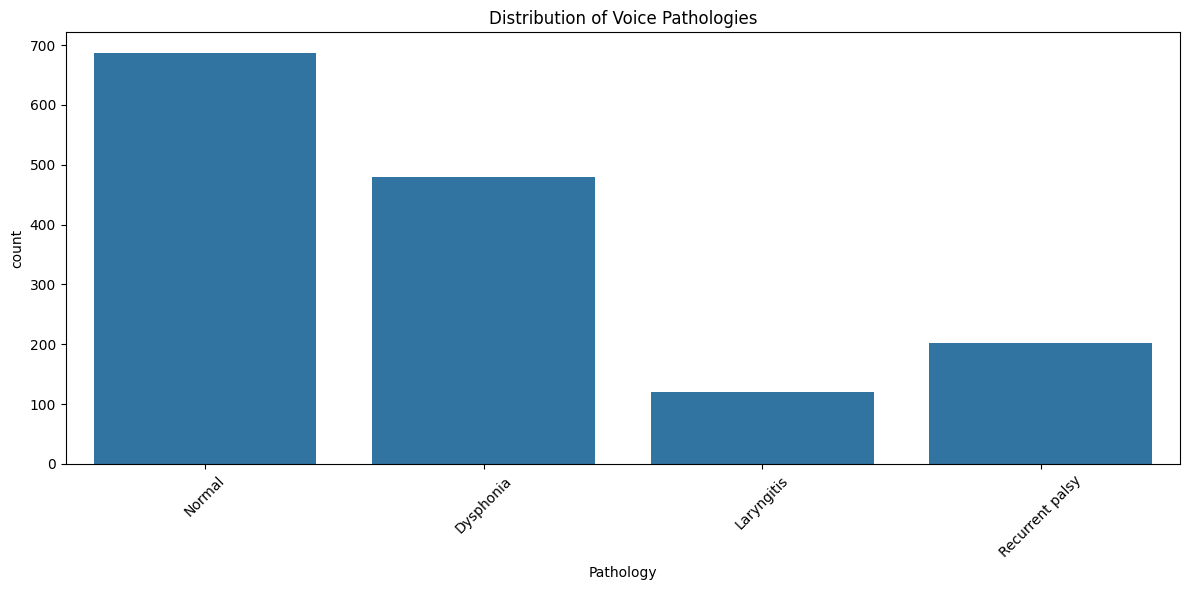

In [7]:
# Plotting pathology distribution
plt.figure(figsize=(12, 6))
sns.countplot(x=df["Pathology"])
plt.title('Distribution of Voice Pathologies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Feature Extraction

Extracting MFCC features from audio files

In [8]:
# Define feature extraction function
audio_dataset_path = 'Filtered_Audio_Dataset/'

def features_extraction(file_name):
    audio, sample_rate = librosa.load(file_name)
    mfccs_features = librosa.feature.mfcc(y=audio, n_mfcc=80)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    
    return mfccs_scaled_features

In [9]:
# Extract features from all audio files
extracted_features = []
for index_num, row in tqdm(df.iterrows()):
    file_name = audio_dataset_path + row["Audio"]
    final_class_labels = row["Type"]
    data = features_extraction(file_name)
    extracted_features.append([data, final_class_labels])

1490it [00:06, 223.68it/s]


In [10]:
# Create DataFrame of extracted features
extracted_features_df = pd.DataFrame(extracted_features, columns=['feature', 'class'])
extracted_features_df.head(10)

,feature,class
0,"[-261.4993, 114.805534, -72.84098, -0.9312808,...",n
1,"[-202.87245, 145.9602, -68.10183, -11.444382, ...",n
2,"[-167.76535, 133.49133, -77.94643, -9.826724, ...",n
3,"[-279.40063, 208.50458, -43.034977, -5.3609724...",n
4,"[-172.24774, 175.08725, -75.93269, 8.991032, -...",n
5,"[-205.02122, 137.12006, -66.55498, -12.496066,...",n
6,"[-217.24478, 145.07858, -100.58555, 2.7787592,...",n
7,"[-227.11813, 127.7593, -63.862732, -13.961371,...",n
8,"[-196.28304, 113.32672, -99.92175, 1.0585614, ...",n
9,"[-207.56131, 135.24808, -61.779495, -17.637136...",n


In [11]:
# Dataset shape after feature extraction
print(f"Extracted features dataframe shape: {extracted_features_df.shape}")

Extracted features dataframe shape: (1490, 2)


In [12]:
# Show a sample feature
extracted_features_df["feature"][0]

array([-2.61499298e+02,  1.14805534e+02, -7.28409805e+01, -9.31280792e-01,
       -6.87778549e+01, -2.90463638e+00,  4.69877434e+00,  7.56695700e+00,
       -3.33708038e+01,  1.76828098e+01, -4.03612280e+00, -1.42697306e+01,
        9.20465469e+00, -2.80942936e+01, -1.00394087e+01, -1.63144569e+01,
       -9.73754048e-01, -4.31138086e+00, -9.75323260e-01, -1.19480648e+01,
        4.30604935e+00, -9.05258465e+00,  8.25751424e-02,  4.08039169e+01,
        2.39141731e+01,  6.14854927e+01,  3.20326614e+01,  8.02177238e+00,
       -2.74809980e+00, -9.03450012e+00,  4.29856777e+00, -1.17523503e+00,
        1.33330669e+01, -6.40946007e+00, -1.52622843e+01, -5.44703436e+00,
        1.03529139e+01, -3.11023283e+00, -8.39599895e+00, -7.93014622e+00,
       -5.57793379e+00,  1.33628874e+01, -4.67779970e+00, -1.73656483e+01,
       -1.20797024e+01,  3.30997658e+00, -6.23456621e+00,  1.79914951e+00,
        1.81635227e+01,  3.11546116e+01,  3.39731255e+01,  2.36189818e+00,
        3.56651634e-01,  

## Data Preparation

In [13]:
# Label Encoding
dummy_data = pd.get_dummies(extracted_features_df['class'])
dummy_data.head()

,n,p
0,True,False
1,True,False
2,True,False
3,True,False
4,True,False


In [14]:
# Prepare data for model
X = np.array(extracted_features_df['feature'].values.tolist())
y = dummy_data.values  # For SVM we use the actual encoded values
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Features shape: (1490, 80)
Labels shape: (1490, 2)


In [15]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training features shape: (1192, 80)
Testing features shape: (298, 80)
Training labels shape: (1192, 2)
Testing labels shape: (298, 2)


## SVM Model Implementation

In [16]:
# Import necessary libraries for SVM
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from datetime import datetime

In [17]:
# We need to use StandardScaler for SVM to work effectively
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Create and train the SVM model
print("Training SVM model...")
start = datetime.now()

# We use OneVsRestClassifier for multi-label classification
svm_model = OneVsRestClassifier(SVC(kernel='rbf', probability=True, C=10))
svm_model.fit(X_train_scaled, y_train)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Training SVM model...
Training completed in time:  0:00:00.898148


In [19]:
# Evaluate the model
y_pred = svm_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.7081


In [20]:
# Generate classification report
print("\nClassification Report:")
target_names = dummy_data.columns.tolist()
print(classification_report(y_test, y_pred, target_names=target_names))


Classification Report:
              precision    recall  f1-score   support

           n       0.68      0.68      0.68       137
           p       0.73      0.73      0.73       161

   micro avg       0.71      0.71      0.71       298
   macro avg       0.71      0.71      0.71       298
weighted avg       0.71      0.71      0.71       298
 samples avg       0.71      0.71      0.71       298



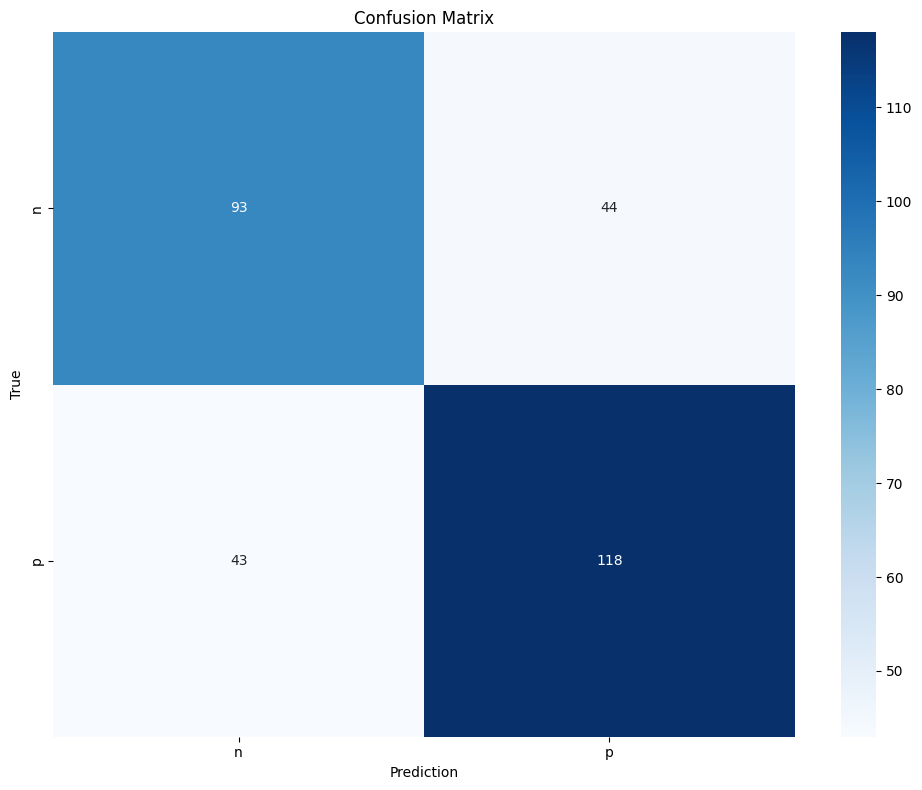

In [21]:
# Create and plot confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=target_names,
           yticklabels=target_names)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## Hyperparameter Tuning

In [22]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'estimator__C': [0.1, 1, 10, 100],
    'estimator__gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'estimator__kernel': ['rbf', 'poly', 'sigmoid']
}

# Create grid search
print("Starting Grid Search for SVM parameters optimization...")
grid_search = GridSearchCV(
    OneVsRestClassifier(SVC(probability=True)),
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Run grid search
grid_search.fit(X_train_scaled, y_train)

Starting Grid Search for SVM parameters optimization...
Fitting 3 folds for each of 60 candidates, totalling 180 fits


GridSearchCV(cv=3,
             estimator=OneVsRestClassifier(estimator=SVC(probability=True)),
             n_jobs=-1,
             param_grid={'estimator__C': [0.1, 1, 10, 100],
                         'estimator__gamma': ['scale', 'auto', 0.01, 0.1, 1],
                         'estimator__kernel': ['rbf', 'poly', 'sigmoid']},
             scoring='accuracy', verbose=1)

In [23]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Best parameters: {'estimator__C': 1, 'estimator__gamma': 0.01, 'estimator__kernel': 'rbf'}
Best cross-validation score: 0.7240


In [24]:
# Train best model
best_svm_model = grid_search.best_estimator_
best_svm_model.fit(X_train_scaled, y_train)

OneVsRestClassifier(estimator=SVC(C=1, gamma=0.01, probability=True))

In [25]:
# Evaluate best model
best_y_pred = best_svm_model.predict(X_test_scaled)
best_accuracy = accuracy_score(y_test, best_y_pred)
print(f"Test accuracy with optimized model: {best_accuracy:.4f}")

Test accuracy with optimized model: 0.7013


In [26]:
# Generate classification report for best model
print("\nClassification Report (Optimized Model):")
print(classification_report(y_test, best_y_pred, target_names=target_names))


Classification Report (Optimized Model):
              precision    recall  f1-score   support

           n       0.67      0.68      0.68       137
           p       0.72      0.72      0.72       161

   micro avg       0.70      0.70      0.70       298
   macro avg       0.70      0.70      0.70       298
weighted avg       0.70      0.70      0.70       298
 samples avg       0.70      0.70      0.70       298



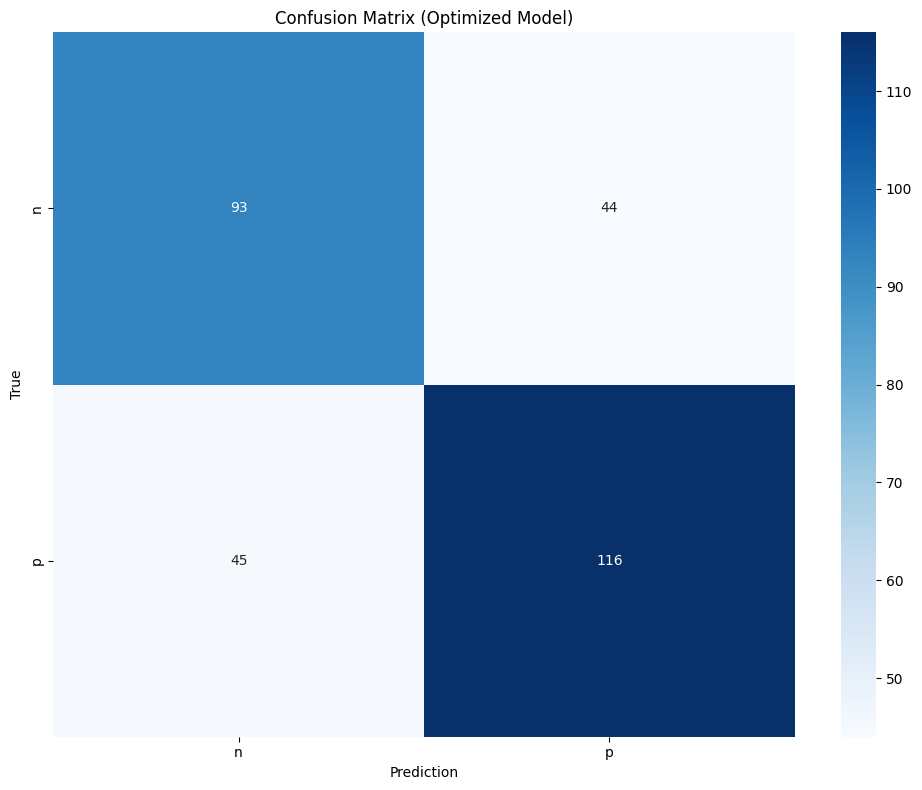

In [27]:
# Create and plot confusion matrix for best model
best_conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(best_y_pred, axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=target_names,
           yticklabels=target_names)
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion Matrix (Optimized Model)')
plt.tight_layout()
plt.show()

## Model Evaluation on Sample File

In [28]:
# Test on a sample file
filename = 'Male_Female_Healthy_Dataset/1004-a_n.wav'
feature_df = pd.DataFrame(features_extraction(filename)).transpose()
features = np.array(feature_df.values.tolist())
features_scaled = scaler.transform(features)
prediction = best_svm_model.predict(features_scaled)
prediction_proba = best_svm_model.predict_proba(features_scaled)

In [29]:
# Print prediction
print("Prediction for sample file:")
predicted_class_index = np.argmax(prediction)
predicted_class = dummy_data.columns[predicted_class_index]
print(f"Predicted class: {predicted_class}")

Prediction for sample file:
Predicted class: n


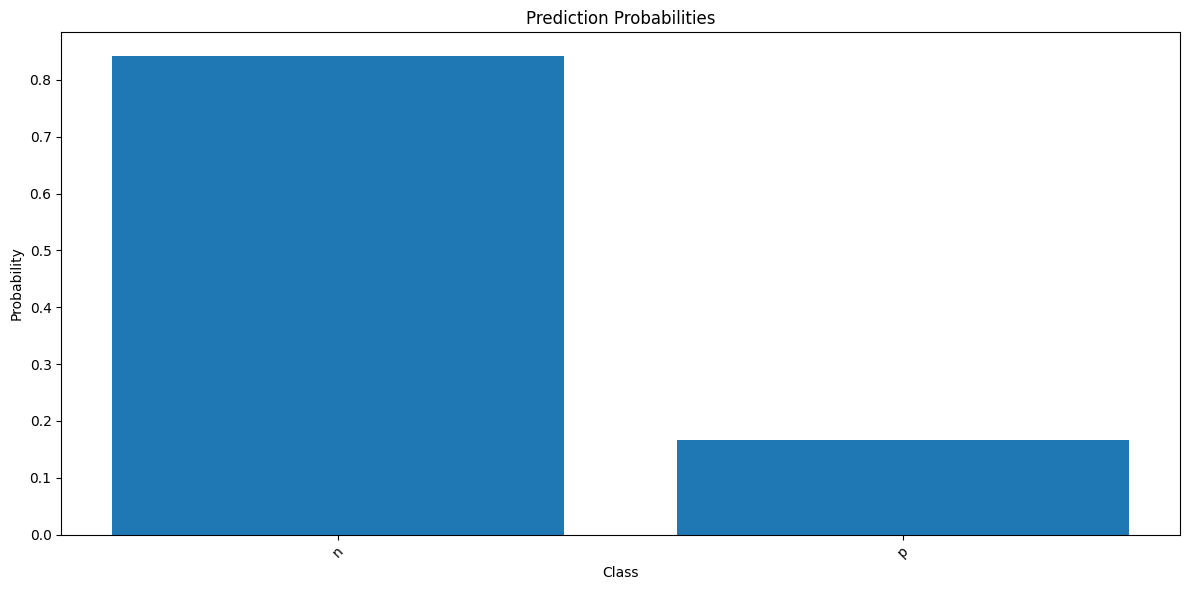

In [30]:
# Plot prediction probabilities
plt.figure(figsize=(12, 6))
plt.bar(dummy_data.columns, prediction_proba[0])
plt.title('Prediction Probabilities')
plt.xlabel('Class')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Save the Model

In [31]:
import joblib
joblib.dump(best_svm_model, 'voice_pathology_svm_model.pkl')
joblib.dump(scaler, 'voice_pathology_scaler.pkl')

['voice_pathology_scaler.pkl']

## Model Comparison (ANN vs SVM)

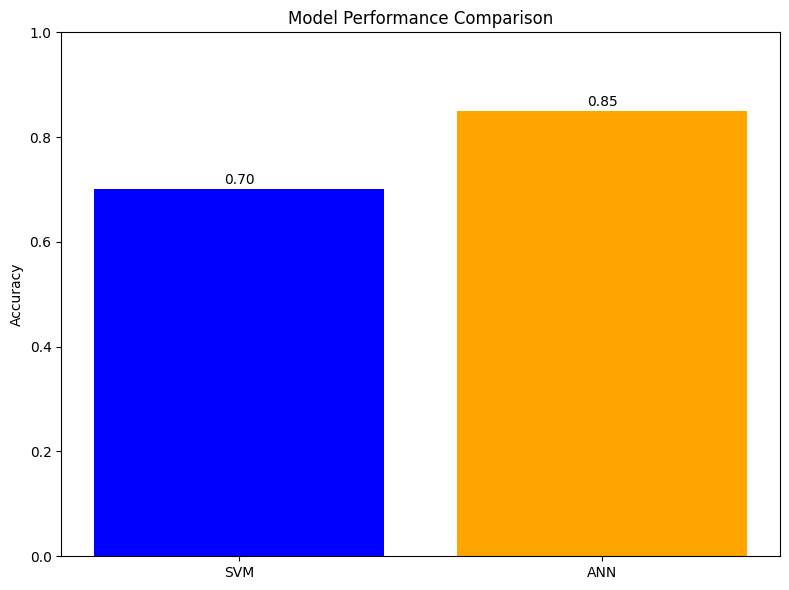

In [32]:
try:
    # Load ANN accuracy from your previous run or use a placeholder
    ann_accuracy = 0.85  # Replace with your actual ANN accuracy from previous run
    
    models = ['SVM', 'ANN']
    accuracies = [best_accuracy, ann_accuracy]
    
    plt.figure(figsize=(8, 6))
    plt.bar(models, accuracies, color=['blue', 'orange'])
    plt.ylim(0, 1.0)
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.01, f'{v:.2f}', ha='center')
    plt.title('Model Performance Comparison')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()
except:
    print("No ANN accuracy available for comparison")

## Utility Function for Making Predictions

In [33]:
def predict_voice_pathology(file_path):
    # Extract features
    features = features_extraction(file_path)
    
    # Scale features
    features_scaled = scaler.transform([features])
    
    # Make prediction
    prediction = best_svm_model.predict(features_scaled)
    prediction_proba = best_svm_model.predict_proba(features_scaled)
    
    # Get predicted class
    predicted_class_index = np.argmax(prediction)
    predicted_class = dummy_data.columns[predicted_class_index]
    
    print(f"Predicted voice type: {predicted_class}")
    print(f"Confidence: {np.max(prediction_proba) * 100:.2f}%")
    
    # Plot probabilities
    plt.figure(figsize=(10, 6))
    plt.bar(dummy_data.columns, prediction_proba[0])
    plt.title(f'Prediction Probabilities for {os.path.basename(file_path)}')
    plt.xlabel('Voice Type')
    plt.ylabel('Probability')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return predicted_class, prediction_proba

Predicted voice type: n
Confidence: 84.17%


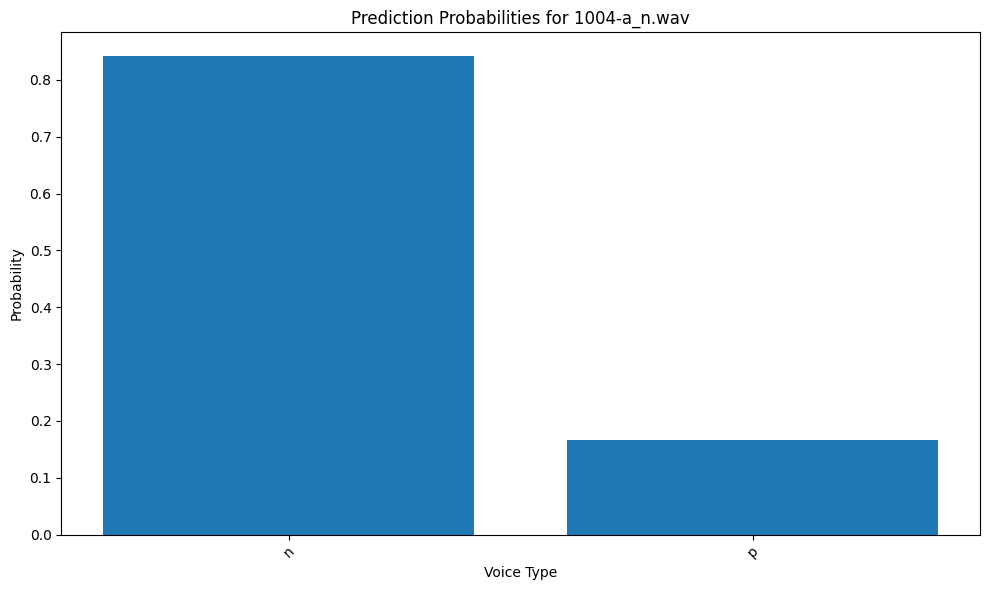

In [34]:
# Test the prediction function
test_file = 'Male_Female_Healthy_Dataset/1004-a_n.wav'
predicted_class, probabilities = predict_voice_pathology(test_file)